# Notebook "6_Besoin_2_Comparaison_Ineris_vs_EPA"


## Description

Ce notebook est en complément de "6_Besoin_2_Comparaison_Ineris_vs_EPA". L'ensemble du notebook se focalise sur la comparaison entre les dnnées INERIS et EPA, plus précisèment, entre les échantillons de type UIOM et les échantillons de type "Municipal Solid Waste Incineration".


## Structure du notebook

Ce notebook est construit de plusieurs parties :
- I. Import des bibliothèques
- II. Préprocessing des données
- III. Comparaison avec les données EPA
- IV. Comparation avec le classifieur entre le Bruit de fond et Emission
- V. Comparation avec les classifieurs sur les données EPA Emission
- VI. Approfondissement de la catégorie "Municipal Waste Solid Incineration"

## Prérequis

### Source de données

Pour que le notebook fonctionne, plusieurs bases de données sont utilisées :
- DB_EPA_BDF_normalized.csv
- DB_EPA_Emission_normalized.csv
- DB_EPA_merge_normalized.csv
- DB_INERIS.csv

### Installation des prérequis techniques

Le notebook fonctionne sur Python 3.7 avec les bibliothèques suivantes :
- pandas
- seaborn
- matplotlib
- numpy
- scipy
- sklearn

# I. Import des libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Machin Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn import tree

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# II. Préprocessing des données

## II.a Définition des variables

In [2]:
substances = ['2378-TCDD', '12378-PeCDD', '123478-HxCDD', '123678-HxCDD',
       '123789-HxCDD', '1234678-HpCDD', 'OCDD', '2378-TCDF', '12378-PeCDF',
       '23478-PeCDF', '123478-HxCDF', '123678-HxCDF', '234678-HxCDF',
       '123789-HxCDF', '1234678-HpCDF', '1234789-HpCDF', 'OCDF']

substances_A = [sub + '_A' for sub in substances]
substances_C = [sub + '_C' for sub in substances]

total_homologue = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'OCDD', 
    'Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'OCDF']

total_dioxine = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'Total DIOXINE']
total_furanne = ['Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'Total FURANE']

## II.b Chargement des données

In [3]:
data = pd.read_csv('DB_INERIS.csv', sep=';')

data = data.rename(columns={"12378-PCDD" : "12378-PeCDD"})
data['Type de point de mesure'].replace({"source":"Source"}, inplace=True)
data = data.replace('-', np.nan)
for col in (substances + total_homologue + ['Total_DIOXINE', 'Total_FURANE']):
    data[col] = data[col].astype(str)
    data[col] = [float(a.replace(',', '.')
                        .replace('94.759.846', "94759.846")
                        .replace('<', '')
                        .replace('ND', '0')
                        .replace('?', '.')
                        .replace(';', '.')
                        .replace('ç', '9')) for a in data[col].values]

In [4]:
columns_process = ['2378-TCDD', '<', '12378-PeCDD', '<.1', '123478-HxCDD',
       '<.2', '123678-HxCDD', '<.3', '123789-HxCDD', '<.4', '1234678-HpCDD',
       '<.5', 'OCDD', '<.6', '2378-TCDF', '<.7', '12378-PeCDF',
       '<.8', '23478-PeCDF', '<.9', '123478-HxCDF', '<.10', '123678-HxCDF',
       '<.11', '234678-HxCDF', '<.12', '123789-HxCDF', '<.13', '1234678-HpCDF',
       '<.14', '1234789-HpCDF', '<.15', 'OCDF', '<.16',
       'Total TCDD', '<.17', 'Total PeCDD', '<.18', 'Total HxCDD', '<.19',
       'Total HpCDD', '<.20', 'Total DIOXINE', '<.21', 'Total TCDF', '<.22',
       'Total PeCDF', '<.23', 'Total HxCDF', '<.24', 'Total HpCDF', '<.25',
       'Total FURANE', '<.26']

for col in columns_process:
    if '<' in col:
        coef = []
        for a in data[col].values:
            if(a == '<' or a == 'ND' or a == 0 or a == '0'):
                coef.append(0)
            else:
                coef.append(1)
        data[old_col] = data[old_col] * coef
    else:
        old_col = col


## II.c Mise en place de la normalisation A

In [5]:
table_final = data.copy()
table_final["total sub 2378"] = 0
for sub in substances:
    table_final["total sub 2378"] += table_final[sub]

In [6]:
table_norme_A = table_final.copy()
for sub in substances:
    table_norme_A[sub + '_A'] = table_norme_A[sub]  / table_final["total sub 2378"]

## II.d Mise en place de la normalisation C

In [7]:
# Choix de la normalisation des congénère OCDD et OCDF
# Valeur True => Normalisation par la concentration total
# Valeur False => Normalisation avec la définition classique
normalisation_C_disc = True

In [8]:
table_norme_C = table_final.copy()

for col in total_homologue:
    table_final["total homologue"] = 0
    table_final["total homologue"] += table_final[col]
table_norme_C = table_final[table_final["total homologue"] > 0]

substance_in = {}
for homologue in total_homologue:
    if(homologue != "OCDD" and homologue != "OCDF"):
        list_sub = []
        text_ref_homologue = homologue.replace("Total ", "")
        table_norme_C[text_ref_homologue] = 0
        for sub in substances:
            if sub.find(text_ref_homologue) != -1:
                list_sub.append(sub)
                table_norme_C[text_ref_homologue] += table_norme_C[sub]
        substance_in[homologue] = list_sub
        text_ref_homologue_2 = text_ref_homologue + "_2"
        table_norme_C[text_ref_homologue_2] = table_norme_C[text_ref_homologue] * 0.9
        table_norme_C = table_norme_C[table_norme_C[text_ref_homologue_2] <= table_norme_C[homologue]]
    else:
        substance_in[homologue] = [homologue]

In [9]:
table_norme_C['TOTAL PCDD'] = table_norme_C['TCDD'] + table_norme_C['PeCDD'] + table_norme_C['HxCDD'] + table_norme_C['HpCDD'] + table_norme_C['OCDD']
table_norme_C['TOTAL PCDF'] = table_norme_C['TCDF'] + table_norme_C['PeCDF'] + table_norme_C['HxCDF'] + table_norme_C['HpCDF'] + table_norme_C['OCDF'] 

for homologue in total_homologue:
    for sub in substance_in[homologue]:
        if sub == 'OCDD':
            if(normalisation_C_disc):
                table_norme_C['OCDD'] = table_norme_C['OCDD'] / table_norme_C['TOTAL PCDD']
            else:
                table_norme_C[sub] = 1
        elif sub == 'OCDF':
            if(normalisation_C_disc):
                table_norme_C['OCDF'] = table_norme_C['OCDF'] / table_norme_C['TOTAL PCDF']
            else:
                table_norme_C[sub] = 1
        else:
            table_norme_C[sub] = table_norme_C[sub] / table_norme_C[homologue]
table_norme_C = table_norme_C.fillna(0)
table_norme_C = table_norme_C.replace(np.inf, 0)
renaming = { pre : nex for (pre, nex) in zip(substances, substances_C) }
table_norme_C = table_norme_C.rename(columns = renaming)

In [10]:
table_total = table_norme_A[["Nom du projet", "Type de point de mesure", "Matrice", "Contexte", "Source", "Fournisseur", "Sous-catégorie"] + substances_A].merge(table_norme_C[substances_C], how='left', left_index=True, right_index=True)
table_total = table_total[table_total["Fournisseur"] != "US EPA"]

## II.d Chargement des données EPA

In [11]:
df_epa = pd.read_csv('DB_EPA_Emission_normalized.csv', sep=';')
df_bdf = pd.read_csv('DB_EPA_BDF_normalized.csv', sep=';')
df_total_epa = pd.read_csv('DB_EPA_merge_normalized.csv', sep=';')

# III. Comparaison avec EPA (Municipal Solid Waste Incineration)

## III.a Visualisation des profils

In [12]:
mesure = "Source" 
data_vs = df_epa[df_epa["source subcategory"] == 'Municipal Solid Waste Incineration'][substances_A + ["source subcategory"]].dropna()
data_ineris = table_total[(table_total["Sous-catégorie"] == 'Déchets solides d\'UIOM') & (table_total["Type de point de mesure"] == mesure)][substances_A + ["Sous-catégorie"]]
data_ineris = data_ineris.dropna()

data_comparison = data_ineris.append(data_vs)
list_source = []
for (check, source1, source2) in zip(pd.isna(data_comparison["source subcategory"]), data_comparison["source subcategory"], data_comparison["Sous-catégorie"]):
    if(check):
        list_source.append(source2)
    else:
        list_source.append(source1)
data_comparison["class"] = list_source
data_comparison = data_comparison[substances_A + ["class"]].dropna()

columns_analysis = substances_A
X = data_comparison[columns_analysis]
y = data_comparison["class"]

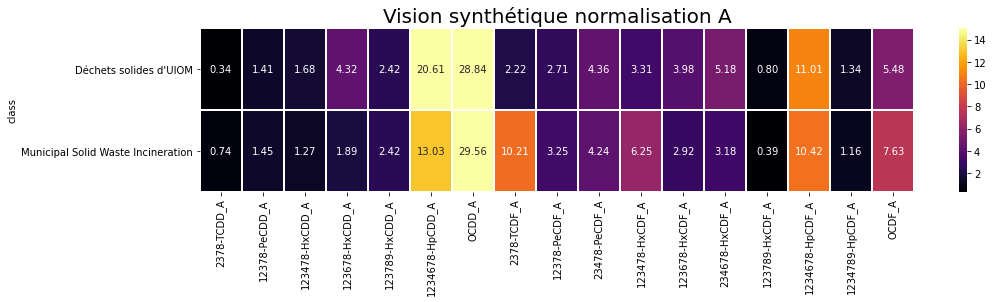

In [13]:
visu = data_comparison.groupby(['class']).mean()

f, ax = plt.subplots(figsize=(16, 3))
plt.title(f"Vision synthétique normalisation A",fontsize=20)
sns.heatmap(visu * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

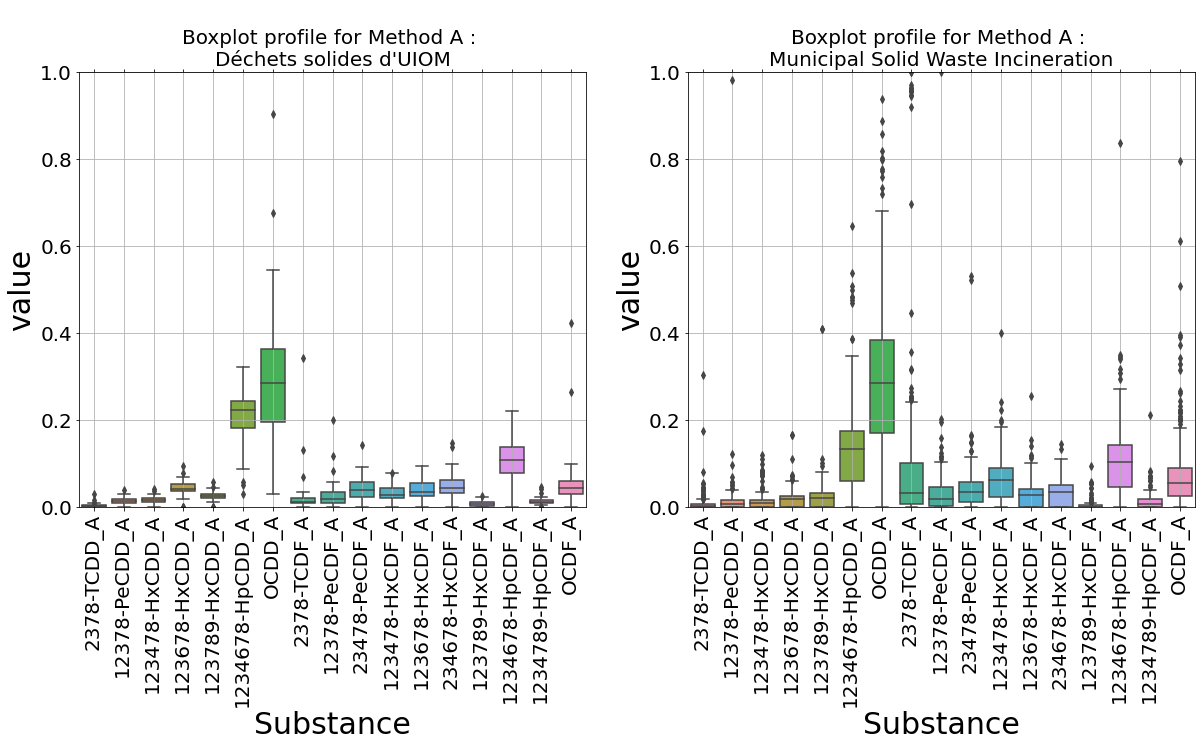

In [14]:
data_long = pd.melt(data_comparison, id_vars=['class'], var_name='Substance')
categories = pd.unique(data_comparison['class'])
f = plt.figure(figsize=(20, 8))
X_axis='Substance'
Y='value'
            
ax = f.add_subplot(1,2, 1)
plt.title("\nBoxplot profile for Method A : \n" + categories[0], fontsize=20)
ax = sns.boxplot(x=X_axis, y=Y, data=data_long[data_long["class"] == categories[0]])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)
ax.set_xlabel(X_axis, fontsize = 30)
ax.set_ylabel(Y, fontsize = 30)
plt.xticks(fontsize = 20, rotation=90)
plt.yticks(fontsize = 20)
plt.ylim(0,1)
plt.grid()

ax = f.add_subplot(1,2, 2)
plt.title("\nBoxplot profile for Method A : \n" + categories[1], fontsize=20)
ax = sns.boxplot(x=X_axis, y=Y, data=data_long[data_long["class"] == categories[1]])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)
ax.set_xlabel(X_axis, fontsize = 30)
ax.set_ylabel(Y, fontsize = 30)
plt.xticks(fontsize = 20, rotation=90)
plt.yticks(fontsize = 20)
plt.ylim(0,1)
plt.grid()

plt.show()

## III.b Mise en place de la méthode LDA

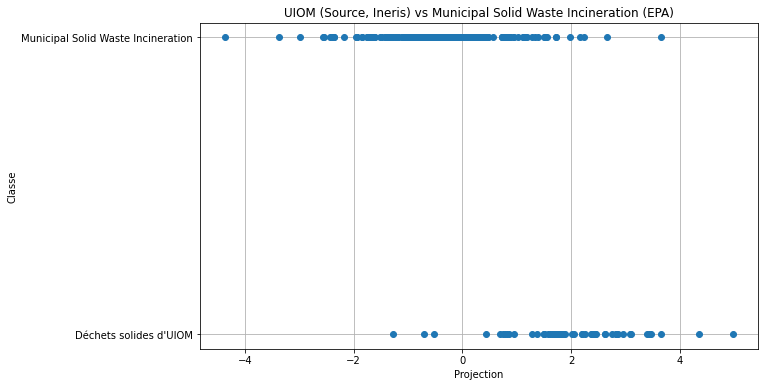

                                    precision    recall  f1-score   support

            Déchets solides d'UIOM       0.81      0.79      0.80        56
Municipal Solid Waste Incineration       0.95      0.96      0.96       262

                          accuracy                           0.93       318
                         macro avg       0.88      0.87      0.88       318
                      weighted avg       0.93      0.93      0.93       318



[Text(0, 0.5, "Déchets solides d'UIOM"),
 Text(0, 1.5, 'Municipal Solid Waste Incineration')]

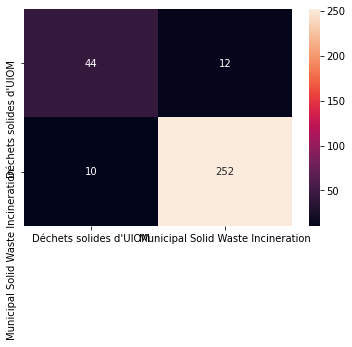

In [15]:
enc = LabelEncoder()
label_encoder = enc.fit(y)

y = label_encoder.transform(y) + 1
label_dict = {i:j for (i,j) in zip(pd.unique(y), pd.unique(label_encoder.inverse_transform(y - 1)))}

sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

plt.figure(figsize=(10, 6))
plt.plot(X_lda_sklearn, [label_dict[value] for value in y], 'o')
plt.title('UIOM (' + mesure + ', Ineris) vs Municipal Solid Waste Incineration (EPA)')
plt.xlabel("Projection")
plt.ylabel("Classe")
plt.grid()
plt.show()

ax= plt.subplot()
y_pred = sklearn_lda.predict(X)
print(classification_report(y, y_pred, target_names=[label_dict[i] for i in sorted(label_dict.keys())]))
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax = ax)
ax.xaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])
ax.yaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])

## III.c Mise en place d'un arbre de décision

In [16]:
mesure = "Source" 
data_vs = df_epa[df_epa["source subcategory"] == 'Municipal Solid Waste Incineration'][substances_A + ["source subcategory", "file", "test date", "run id"]].dropna()
data_ineris = table_total[(table_total["Sous-catégorie"] == 'Déchets solides d\'UIOM') & (table_total["Type de point de mesure"] == mesure)][substances_A + ["Sous-catégorie", "Nom du projet"]]
data_ineris = data_ineris.dropna()
data_comparison = data_ineris.copy()
data_comparison = data_comparison.append(data_vs)
list_source = []
for (check, source1, source2) in zip(pd.isna(data_comparison["source subcategory"]), data_comparison["source subcategory"], data_comparison["Sous-catégorie"]):
    if(check):
        list_source.append(source2)
    else:
        list_source.append(source1)
data_comparison["class"] = list_source
data_comparison = data_comparison[substances_A + ["class"]].dropna()
data_comparison[substances_A] = data_comparison[substances_A] * 100

train,test=train_test_split(data_comparison,test_size=0.2,random_state=0,stratify=data_comparison['class'])
train_X=train[substances_A]
train_Y=train['class']
test_X=test[substances_A]
test_Y=test['class']
X=data_comparison[substances_A]
Y=data_comparison['class']

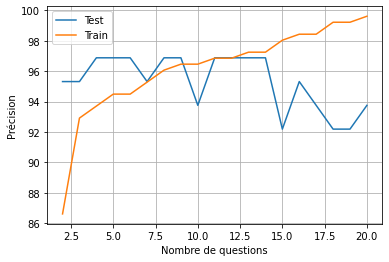

In [17]:
acc_test=[]
acc_train=[]
for i in range(2,21):
    model=DecisionTreeClassifier(max_leaf_nodes=i)
    model.fit(train_X,train_Y)
    predic_train = model.predict(train_X)
    prediction4=model.predict(test_X)
    acc_test.append(metrics.accuracy_score(prediction4,test_Y))
    acc_train.append(metrics.accuracy_score(predic_train,train_Y))
plt.plot(range(2,21), [i * 100 for i in acc_test], label='Test')
plt.plot(range(2,21), [i * 100 for i in acc_train], label='Train')
plt.xlabel("Nombre de questions")
plt.ylabel("Précision")
plt.legend()
plt.grid()

In [18]:
model=DecisionTreeClassifier(max_leaf_nodes=4)
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y) * 100, "%")

The accuracy of the Decision Tree is 96.875 %


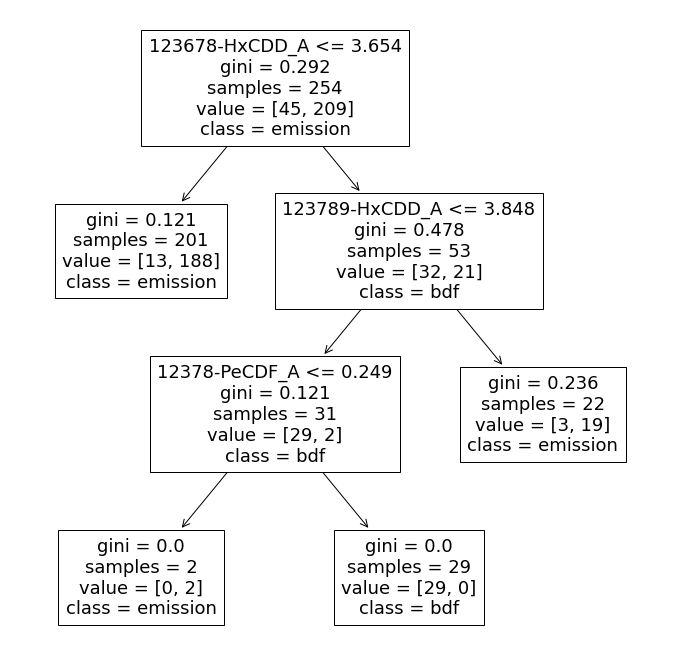

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
_=tree.plot_tree(model, feature_names=list(train_X.columns), class_names=['bdf', 'emission'])

# IV. Comparation avec le classifieur entre le Bruit de fond et Emission

In [20]:
df_epa_norma_A = df_total_epa[substances_A + ['label']].dropna()
train,test=train_test_split(df_epa_norma_A,test_size=0.3,random_state=0,stratify=df_epa_norma_A['label'])
train_X=train[substances_A]
train_Y=train[train.columns[-1:]]
test_X=test[substances_A]
test_Y=test[test.columns[-1:]]
X=df_epa_norma_A[substances_A]
Y=df_epa_norma_A['label']

In [21]:
model_EPA_split=DecisionTreeClassifier(max_leaf_nodes=5)
model_EPA_split.fit(train_X,train_Y)
prediction4=model_EPA_split.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y) * 100, "%")

The accuracy of the Decision Tree is 94.7841726618705 %


In [22]:
predict_ineris = model_EPA_split.predict(data_ineris[substances_A])
print('The accuracy of the Ineris Data is', metrics.accuracy_score(predict_ineris, ['emission' for i in range(len(predict_ineris))]) * 100, "%")

The accuracy of the Ineris Data is 96.42857142857143 %


# V. Comparation avec les classifieurs sur les données EPA Emission

## V.a Analyse de la volumétrie

In [24]:
list_sub = ["Cement Kilns",
        "Hazardous Waste Incineration",
        "Medical Waste Incineration",
        "Municipal Solid Waste Incineration",
        "Sewage Sludge Incineration",
        "Wastewater Sludge at Bleached Chemical Pulp Mills"]
data_epa_emission = df_epa[df_epa["source subcategory"].isin(list_sub)][substances_A + ['source subcategory']].dropna()
print("Sous-catégories : ", len(list_sub))

data_ineris = table_total[(table_total["Source"] == 'UIOM') & (table_total["Type de point de mesure"] == "Source")][substances_A + ["Source", "Nom du projet"]]
data_ineris = data_ineris.dropna()

Sous-catégories :  6


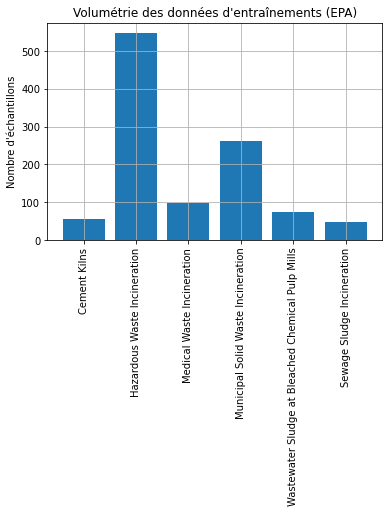

In [25]:
plt.bar(pd.unique(data_epa_emission["source subcategory"]), [len(data_epa_emission[data_epa_emission["source subcategory"] == source]) for source in pd.unique(data_epa_emission["source subcategory"])])
plt.xticks(fontsize = 10, rotation=90)
plt.title("Volumétrie des données d'entraînements (EPA)")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

## V.b Mise en place d'un classifieur (Random Forest)

In [26]:
train,test=train_test_split(data_epa_emission,test_size=0.3,random_state=0,stratify=data_epa_emission['source subcategory'])
train_X=train[substances_A]
train_Y=train['source subcategory']
test_X=test[substances_A]
test_Y=test['source subcategory']
X=data_epa_emission[substances_A]
Y=data_epa_emission['source subcategory']

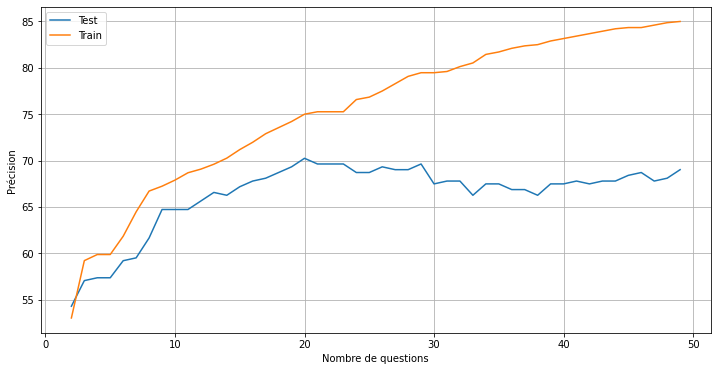

In [27]:
acc_test=[]
acc_train=[]
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(2,50):
    model=DecisionTreeClassifier(max_leaf_nodes=i)
    model.fit(train_X,train_Y)
    predic_train = model.predict(train_X)
    prediction4=model.predict(test_X)
    acc_test.append(metrics.accuracy_score(prediction4,test_Y))
    acc_train.append(metrics.accuracy_score(predic_train,train_Y))
plt.plot(range(2,50), [i * 100 for i in acc_test], label='Test')
plt.plot(range(2,50), [i * 100 for i in acc_train], label='Train')
plt.xlabel("Nombre de questions")
plt.ylabel("Précision")
plt.legend()
plt.grid()


In [28]:
model_EPA=DecisionTreeClassifier(max_leaf_nodes=10)
model_EPA.fit(train_X,train_Y)
prediction = model_EPA.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction,test_Y) * 100, "%")

The accuracy of the Decision Tree is 64.7239263803681 %


## V.c Résultat du classifieur

In [29]:
predict_ineris = model_EPA.predict(data_ineris[substances_A])
print('The accuracy of the Ineris Data is', metrics.accuracy_score(predict_ineris, ['Municipal Solid Waste Incineration' for i in range(len(predict_ineris))]) * 100, "%")

The accuracy of the Ineris Data is 74.54545454545455 %


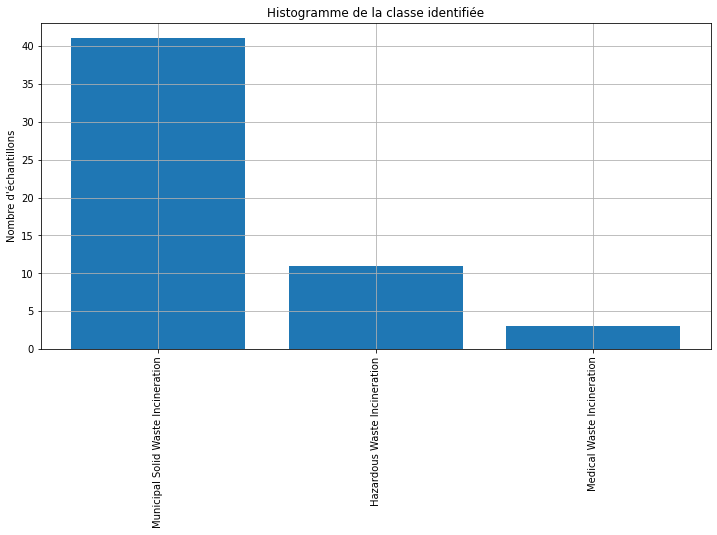

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(pd.unique(predict_ineris), [len(predict_ineris[predict_ineris == source]) for source in pd.unique(predict_ineris)])
plt.title("Histogramme de la classe identifiée")
plt.ylabel("Nombre d'échantillons")
plt.xticks(fontsize = 10, rotation=90)
plt.grid()

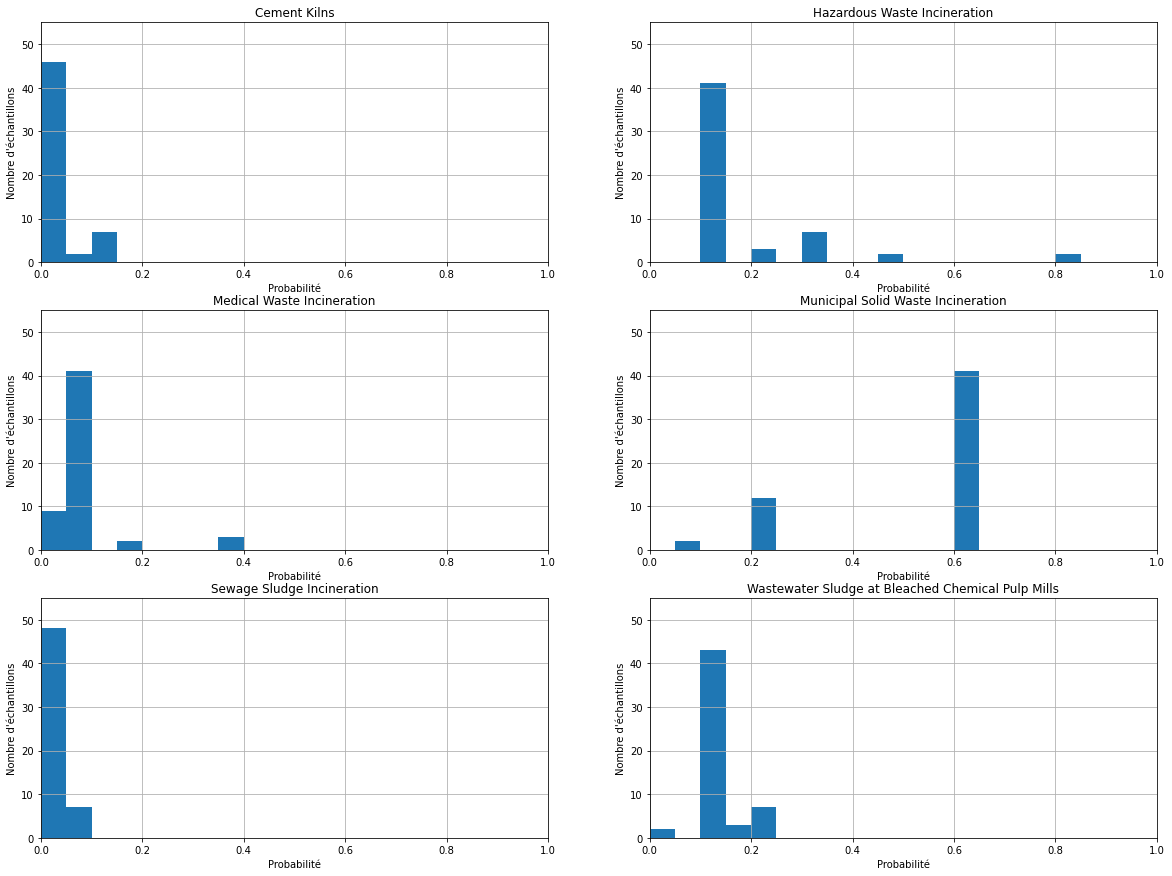

In [31]:
proba = model_EPA.predict_proba(data_ineris[substances_A])
f = plt.figure(figsize=(20, 15))
for i, subs in enumerate(list_sub):
    ax = f.add_subplot(3,2, i + 1)
    ax.hist(proba[:,i], range = [0, 1], bins = 20)
    plt.xlim(0,1)
    plt.ylim(0,55)
    plt.title(subs)
    plt.ylabel("Nombre d'échantillons")
    plt.xlabel("Probabilité")
    plt.grid()
    plt.show

In [32]:
data_ineris["Predict"] = predict_ineris
data_resume = data_ineris[["Predict", "Nom du projet"]]
list_projects = pd.unique(data_resume["Nom du projet"])

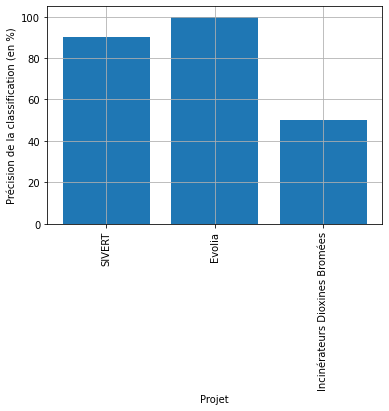

In [33]:
plt.bar(list_projects, [metrics.accuracy_score(data_resume[data_resume["Nom du projet"] == projet]["Predict"], ['Municipal Solid Waste Incineration' for i in range(len(data_resume[data_resume["Nom du projet"] == projet]["Predict"]))]) * 100 for projet in list_projects])
plt.xticks(fontsize = 10, rotation=90)
plt.xlabel("Projet")
plt.ylabel("Précision de la classification (en %)")
plt.grid()
plt.show()

# VI. Approfondissement de la catégorie "Municipal Waste Solid Incineration"

## VI.a Première utilisation d'une analyse non supervisée

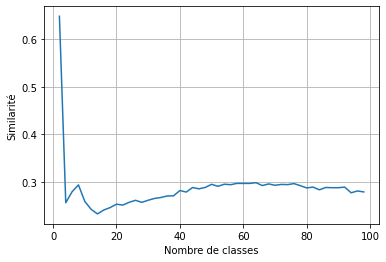

In [34]:
sil = []
kmax = len(data_vs[substances_A])

for k in range(2, 100, 2):
    avg = []
    for i in range(5):
        kmeans = KMeans(n_clusters = k).fit(data_vs[substances_A])
        labels = kmeans.labels_
        avg.append(silhouette_score(data_vs[substances_A], labels, metric = 'euclidean'))
    sil.append(np.mean(avg))
    
plt.plot([i for i in range(2, 100, 2)], sil)
plt.xlabel("Nombre de classes")
plt.ylabel("Similarité")
plt.grid()
plt.show()

In [35]:
normalized_df = (data_vs[substances_A]-data_vs[substances_A].mean())/data_vs[substances_A].std()
sil = []
kmax = len(normalized_df)

for k in range(2, 100, 2):
    avg = []
    for i in range(5):
        kmeans = KMeans(n_clusters = k).fit(normalized_df)
        labels = kmeans.labels_
        avg.append(silhouette_score(normalized_df, labels, metric = 'euclidean'))
    sil.append(np.mean(avg))

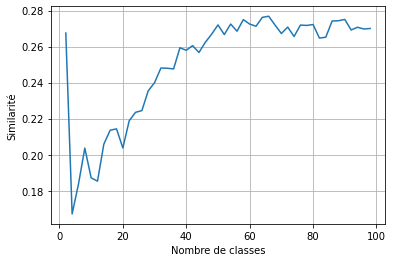

In [36]:
plt.plot([i for i in range(2, 100, 2)], sil)
plt.xlabel("Nombre de classes")
plt.ylabel("Similarité")
plt.grid()

## VI.b Classes obtenues à l'aide du premier k-means

In [37]:
kmeans = KMeans(n_clusters = 2).fit(data_vs[substances_A])
labels = kmeans.labels_

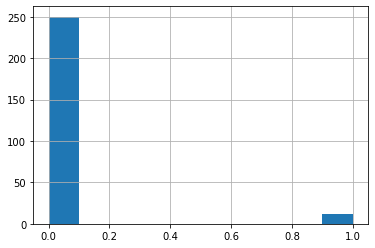

In [38]:
plt.hist(labels)
plt.grid()

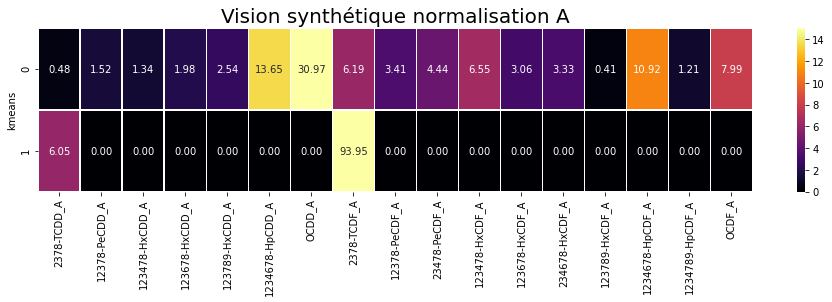

In [39]:
data_vs["kmeans"] = labels

visu = data_vs.groupby(['kmeans']).mean()

f, ax = plt.subplots(figsize=(16, 3))
plt.title(f"Vision synthétique normalisation A",fontsize=20)
sns.heatmap(visu * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

## VI.c Résultat du classifieur sans la classe d'outlier

In [40]:
list_sub = ["Cement Kilns",
        "Hazardous Waste Incineration",
        "Medical Waste Incineration",
        "Sewage Sludge Incineration",
        "Wastewater Sludge at Bleached Chemical Pulp Mills"]

data_epa_emission = df_epa[df_epa["source subcategory"].isin(list_sub)][substances_A + ['source subcategory']].dropna()
data_municipal = df_epa[df_epa["source subcategory"] == "Municipal Solid Waste Incineration"][substances_A + ["source subcategory", "file", "test date", "run id"]].dropna()
data_municipal["labels"] = labels
if (len(data_municipal[data_municipal["labels"] == 1]) > len(data_municipal[data_municipal["labels"] == 0])):
        data_municipal = data_municipal[data_municipal["labels"] == 1]
else:
        data_municipal = data_municipal[data_municipal["labels"] == 0]

data_epa_emission = data_epa_emission.append(data_municipal[substances_A + ['source subcategory']])

data_ineris = table_total[(table_total["Source"] == 'UIOM') & (table_total["Type de point de mesure"] == "Source")][substances_A + ["Source", "Nom du projet"]]

data_ineris = data_ineris.dropna()

In [41]:
train,test=train_test_split(data_epa_emission,test_size=0.3,random_state=0,stratify=data_epa_emission['source subcategory'])
train_X=train[substances_A]
train_Y=train['source subcategory']
test_X=test[substances_A]
test_Y=test['source subcategory']
X=data_epa_emission[substances_A]
Y=data_epa_emission['source subcategory']

In [42]:
model_EPA=DecisionTreeClassifier(max_leaf_nodes=10)
model_EPA.fit(train_X,train_Y)
prediction = model_EPA.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction,test_Y) * 100, "%")

The accuracy of the Decision Tree is 61.60990712074303 %


In [43]:
predict_ineris = model_EPA.predict(data_ineris[substances_A])
print('The accuracy of the Ineris Data is', metrics.accuracy_score(predict_ineris, ['Municipal Solid Waste Incineration' for i in range(len(predict_ineris))]) * 100, "%")

The accuracy of the Ineris Data is 61.81818181818181 %


## VI.d Classes obtenues à l'aide du second k-means

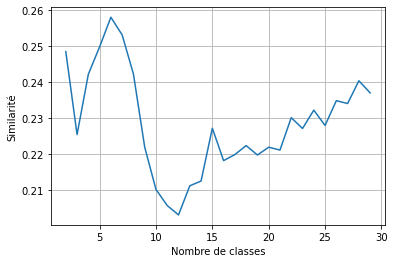

In [44]:
sil = []
kmax = len(data_municipal[substances_A])

for k in range(2, 30, 1):
    avg = []
    for i in range(20):
        kmeans = KMeans(n_clusters = k).fit(data_municipal[substances_A])
        labels = kmeans.labels_
        avg.append(silhouette_score(data_municipal[substances_A], labels, metric = 'euclidean'))
    sil.append(np.mean(avg))
    
plt.plot([i for i in range(2, 30)], sil)
plt.xlabel("Nombre de classes")
plt.ylabel("Similarité")
plt.grid()
plt.show()

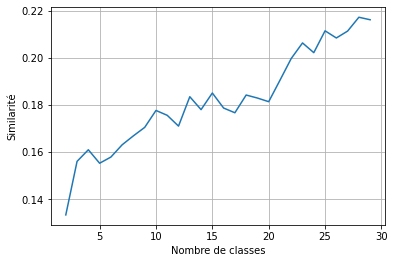

In [45]:
sil = []
normalized_df = (data_municipal[substances_A]-data_municipal[substances_A].mean())/data_municipal[substances_A].std()
kmax = len(data_municipal[substances_A])

for k in range(2, 30):
    avg = []
    for i in range(20):
        kmeans = KMeans(n_clusters = k).fit(normalized_df[substances_A])
        labels = kmeans.labels_
        avg.append(silhouette_score(normalized_df[substances_A], labels, metric = 'euclidean'))
    sil.append(np.mean(avg))
    
plt.plot([i for i in range(2, 30)], sil)
plt.xlabel("Nombre de classes")
plt.ylabel("Similarité")
plt.grid()
plt.show()

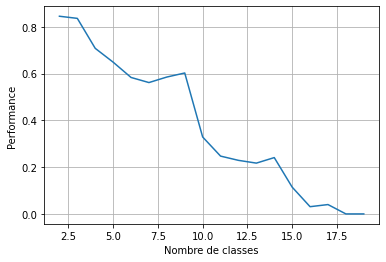

In [46]:
sil = []
kmax = len(data_municipal[substances_A])

for k in range(2, 20, 1):
    avg = []
    for i in range(20):
        kmeans = KMeans(n_clusters = k).fit(data_municipal[substances_A])
        labels = kmeans.labels_
        data_copy = data_municipal.copy()
        data_copy["kmeans"] = labels
        data_copy["source subcategory"] = [i + str(j) for (i, j) in zip(data_copy["source subcategory"].values, data_copy["kmeans"].values)]
        list_sub = ["Cement Kilns",
        "Hazardous Waste Incineration",
        "Medical Waste Incineration",
        "Sewage Sludge Incineration",
        "Wastewater Sludge at Bleached Chemical Pulp Mills"]
        data_epa_emission = df_epa[df_epa["source subcategory"].isin(list_sub)][substances_A + ['source subcategory']].dropna()

        for i in range(k):
            if(len(data_copy[data_copy["kmeans"] == i]) < 2):
                data_copy = data_copy[data_copy["kmeans"] != i]

        data_epa_emission = data_epa_emission.append(data_copy[substances_A + ['source subcategory']])

        data_ineris = table_total[(table_total["Source"] == 'UIOM') & (table_total["Type de point de mesure"] == "Source")][substances_A + ["Source", "Nom du projet"]]

        data_ineris = data_ineris.dropna()

        train,test=train_test_split(data_epa_emission,test_size=0.2,random_state=0,stratify=data_epa_emission['source subcategory'])
        train_X=train[substances_A]
        train_Y=train['source subcategory']
        test_X=test[substances_A]
        test_Y=test['source subcategory']
        X=data_epa_emission[substances_A]
        Y=data_epa_emission['source subcategory']

        model_EPA=DecisionTreeClassifier(max_leaf_nodes=5)
        model_EPA.fit(train_X,train_Y)
        prediction = model_EPA.predict(test_X)

        predict_ineris = model_EPA.predict(data_ineris[substances_A])
        acc = []
        for predict in predict_ineris:
            if "Municipal Solid Waste Incineration" in predict:
                acc.append(1)
            else:
                acc.append(0)
        avg.append(np.mean(acc))

    sil.append(np.mean(avg))
    
plt.plot([i for i in range(2, 20)], sil)
plt.xlabel("Nombre de classes")
plt.ylabel("Performance")
plt.grid()
plt.show()

## VI.e Analyse des 5 classes obtenues

In [47]:
nb_class = 5
kmeans = KMeans(n_clusters = nb_class).fit(data_municipal[substances_A])

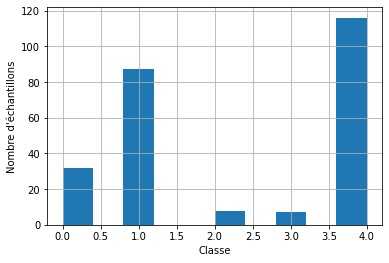

In [48]:
labels = kmeans.labels_
plt.hist(labels)
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.grid()

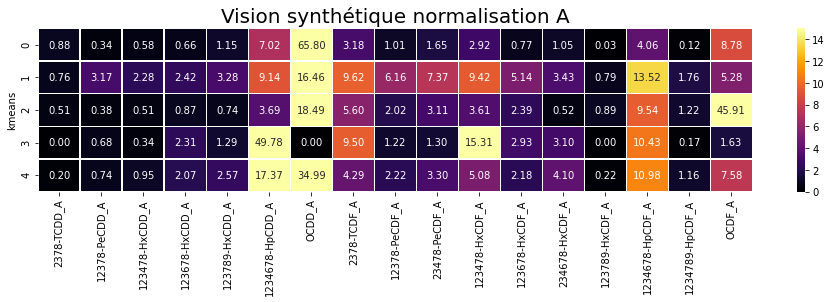

In [49]:
data_municipal["kmeans"] = labels

visu = data_municipal[substances_A + ["kmeans"]].groupby(['kmeans']).mean()

f, ax = plt.subplots(figsize=(16, 3))
plt.title(f"Vision synthétique normalisation A",fontsize=20)
sns.heatmap(visu * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

## VI.f Résultat du classifieur à l'aide des 5 classes

In [50]:
data_municipal["source subcategory"] = [ "Municipal Solid Waste Incineration" + str(j) for (i, j) in zip(data_municipal["source subcategory"].values, data_municipal["kmeans"].values)]

In [51]:
list_sub = ["Cement Kilns",
        "Hazardous Waste Incineration",
        "Medical Waste Incineration",
        "Sewage Sludge Incineration",
        "Wastewater Sludge at Bleached Chemical Pulp Mills"]
data_epa_emission = df_epa[df_epa["source subcategory"].isin(list_sub)][substances_A + ['source subcategory']].dropna()

for i in range(nb_class):
    if(len(data_municipal[data_municipal["kmeans"] == i]) < 2):
        data_municipal = data_municipal[data_municipal["kmeans"] != i]

data_epa_emission = data_epa_emission.append(data_municipal[substances_A + ['source subcategory']])

data_ineris = table_total[(table_total["Source"] == 'UIOM') & (table_total["Type de point de mesure"] == "Source")][substances_A + ["Source", "Nom du projet"]]

data_ineris = data_ineris.dropna()

In [52]:
train,test=train_test_split(data_epa_emission,test_size=0.2,random_state=0,stratify=data_epa_emission['source subcategory'])
train_X=train[substances_A]
train_Y=train['source subcategory']
test_X=test[substances_A]
test_Y=test['source subcategory']
X=data_epa_emission[substances_A]
Y=data_epa_emission['source subcategory']

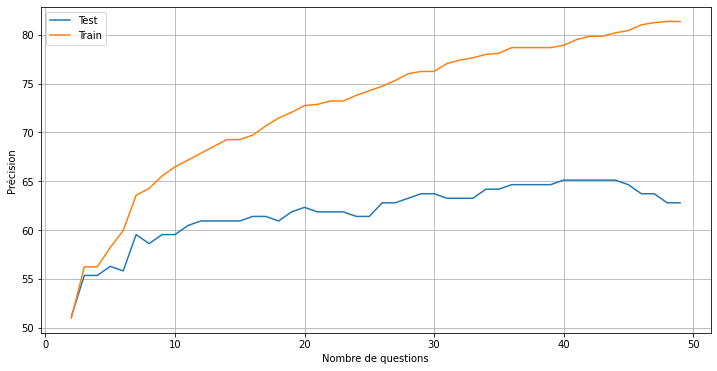

In [53]:
acc_test=[]
acc_train=[]
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(2,50):
    model=DecisionTreeClassifier(max_leaf_nodes=i)
    model.fit(train_X,train_Y)
    predic_train = model.predict(train_X)
    prediction4=model.predict(test_X)
    acc_test.append(metrics.accuracy_score(prediction4,test_Y))
    acc_train.append(metrics.accuracy_score(predic_train,train_Y))
plt.plot(range(2,50), [i * 100 for i in acc_test], label='Test')
plt.plot(range(2,50), [i * 100 for i in acc_train], label='Train')
plt.xlabel("Nombre de questions")
plt.ylabel("Précision")
plt.legend()
plt.grid()

In [54]:
model_EPA=DecisionTreeClassifier(max_leaf_nodes=5)
model_EPA.fit(train_X,train_Y)
prediction = model_EPA.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction,test_Y) * 100, "%")

The accuracy of the Decision Tree is 56.27906976744186 %


In [55]:
predict_ineris = model_EPA.predict(data_ineris[substances_A])
acc = []
for predict in predict_ineris:
    if "Municipal Solid Waste Incineration" in predict:
        acc.append(1)
    else:
        acc.append(0)
print('The accuracy of the Decision Tree is',np.mean(acc) * 100, "%")

The accuracy of the Decision Tree is 83.63636363636363 %


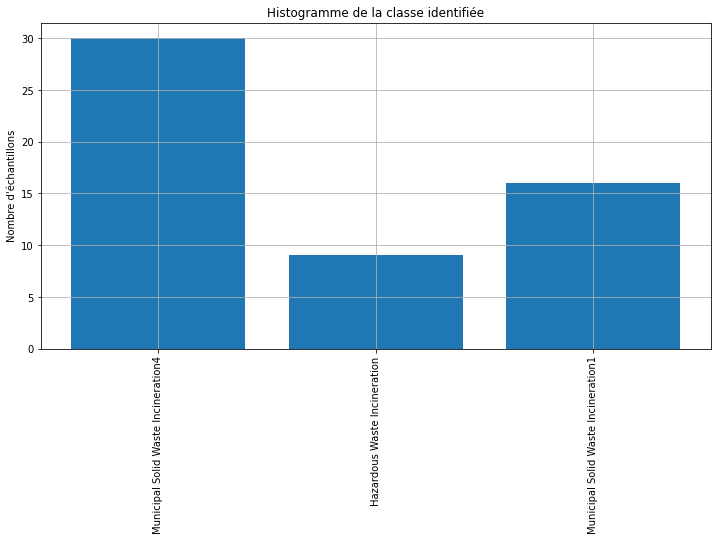

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(pd.unique(predict_ineris), [len(predict_ineris[predict_ineris == source]) for source in pd.unique(predict_ineris)])
plt.title("Histogramme de la classe identifiée")
plt.ylabel("Nombre d'échantillons")
plt.xticks(fontsize = 10, rotation=90)
plt.grid()

## VI.g Analyse des réultats de prédictions obtenues par le classifieur

In [57]:
data_ineris["Predict"] = predict_ineris
data_ineris["True value"] = acc
data_resume = data_ineris[["Predict", "Nom du projet", "True value"]]

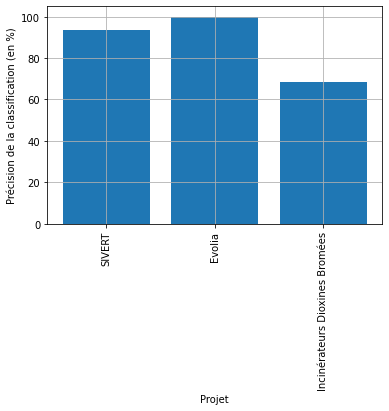

In [58]:
plt.bar(list_projects, [np.mean(data_resume[data_resume["Nom du projet"] == projet]["True value"].values) * 100 for projet in list_projects])
plt.xticks(fontsize = 10, rotation=90)
plt.xlabel("Projet")
plt.ylabel("Précision de la classification (en %)")
plt.grid()
plt.show()

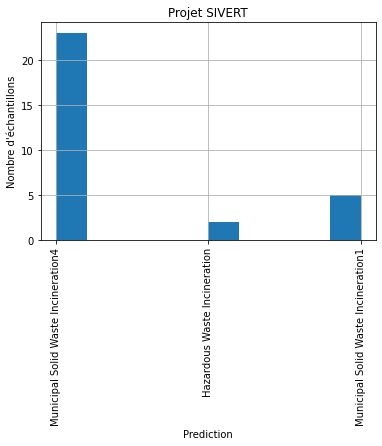

In [59]:
plt.hist(data_ineris[data_ineris["Nom du projet"] == "SIVERT"][["Predict"]].values)
plt.xticks(fontsize = 10, rotation=90)
plt.xlabel("Prediction")
plt.ylabel("Nombre d'échantillons")
plt.title("Projet SIVERT")
plt.grid()
plt.show()

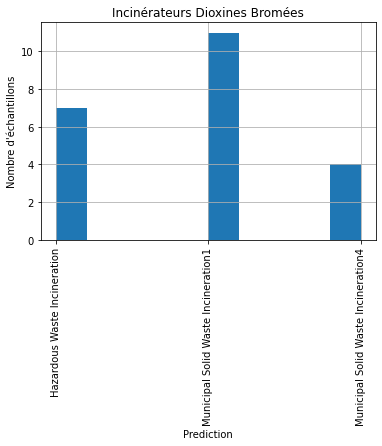

In [60]:
plt.hist(data_ineris[data_ineris["Nom du projet"] == "Incinérateurs Dioxines Bromées"][["Predict"]].values)
plt.xticks(fontsize = 10, rotation=90)
plt.xlabel("Prediction")
plt.ylabel("Nombre d'échantillons")
plt.title("Incinérateurs Dioxines Bromées")
plt.grid()
plt.show()